By: 

* Jason Tompkins
* Elissa Carroll
* Thomas Marianos
* Thomas McGuire

In [ ]:
# Make the format such that figures will display nicely in the pdf of this document. 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Introduction

For our group project, we chose to look at information available from Spotify on what people are currently listening to. To do this, we utilized a data set off of Kaggle; previous students had organized Spotify data into csv files containing streaming information from 2017 to 2020. We built off their project to focus on exploring what Spotify could tell us about the streaming music industry.  

Each year in the US, over 34 thousand new people claim to be singers or musicians on their tax returns. This means that there are far more than 34K people who are entering the music industry each year. However, studies show that only 1% of musicians stay in their field after the first year; this represents the huge amount of turnover and competition in the market. We wanted to utilize the Spotify data to get a better feel for that market. 

One of the aspects of streaming platforms like Spotify is the ability to easily discover new music. Spotify’s recommendation system is based off the sound qualities of the music you listen to but especially the genre of music. We chose to dive into an exploration of the relationship between Genre and music qualities, country, year, and a few other attributes.  


# Libraries

In [ ]:
import pandas as pd
from pandas.core.algorithms import quantile
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
import six

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Data Sources

The Kaggle data had two data sources: a final csv and a csv to calculate popularity. Between them, they contain all songs that made it into Spotify's top 200 daily for the years 2017 through 2020 for each of 35 Countries as well as a Global category. The data is a mix of numeric and categorical variables numbering 151 attributes and > 170,000 rows in the final csv and 8 attributes by > 9,800,000 rows in the popularity csv. The students who put together these data sources provided fairly clean csv files; predominately, the "cleaning" you wil see below is deciding which columns to keep as well as how to deal with NaN values.

The majority of our attention was focused on the final csv though we did use the popularity csv for some EDA and initial exploration of song Genre related to song Position. 

## Connect to Drive and set wd

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#Change the directory to our google Drive
  #Elissa
%cd /content/drive/My\ Drive/

/content/drive/My Drive


## Data Munging 

### Final CSV

Read in data and look at basic descriptive statistics.

In [ ]:
#Read in Final Database csv
finalDat = pd.read_csv("Final database.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#print(finalDat.head(n=2))
#print(finalDat.describe())
print(finalDat.shape)

(170633, 151)


Clean final csv to remove unwanted columns.

In [ ]:
#Remove all columns from 109 (bing_norm_negative) to 112 (Argentina) to 146 (USA)
noDummies = finalDat.drop(finalDat.iloc[:,109:147], axis = 1)
noDummies.drop(noDummies.iloc[:,74:100], axis = 1, inplace=True) #anger_norm to Positive_Bayes
noDummies.drop(noDummies.iloc[:,55:58], axis = 1, inplace=True) #syuzhet_norm	to nrc_norm
noDummies.drop(noDummies.iloc[:,29:31], axis = 1, inplace=True) #explicit_false and explicit_true

In [ ]:
# Change the column names with a slash
noDummies = noDummies.rename(columns={'Album/Single': 'AlbumSingle', 'mode': 'trackMode', 'dance/electronic': 'danceElectronic'})

# Transform the data types 
noDummies['Country'] = noDummies.Country.astype('category')
noDummies['AlbumSingle'] = noDummies.AlbumSingle.astype('category')
noDummies['Genre'] = noDummies.Genre.astype('category')
noDummies['Artist_followers'] = pd.to_numeric(noDummies.Artist_followers, errors='coerce')
noDummies['Explicit'] = noDummies.Explicit.astype('category')
noDummies['Release_date'] = pd.to_datetime(noDummies.Release_date, format='%Y-%m-%d', errors='coerce')
noDummies['Track_number'] = pd.to_numeric(noDummies.Track_number, errors='coerce')
noDummies['Tracks_in_album'] = pd.to_numeric(noDummies.Tracks_in_album, errors='coerce')
noDummies['danceability'] = pd.to_numeric(noDummies.danceability, errors='coerce')
noDummies['energy'] = pd.to_numeric(noDummies.energy, errors='coerce')
noDummies['key'] = pd.to_numeric(noDummies.key, errors='coerce')
noDummies['loudness'] = pd.to_numeric(noDummies.loudness, errors='coerce')
noDummies['trackMode'] = pd.to_numeric(noDummies.trackMode, errors='coerce')
noDummies['speechiness'] = pd.to_numeric(noDummies.speechiness, errors='coerce')
noDummies['acoustics'] = pd.to_numeric(noDummies.acoustics, errors='coerce')
noDummies['instrumentalness'] = pd.to_numeric(noDummies.instrumentalness, errors='coerce')
noDummies['liveliness'] = pd.to_numeric(noDummies.liveliness, errors='coerce')
noDummies['valence'] = pd.to_numeric(noDummies.valence, errors='coerce')
noDummies['tempo'] = pd.to_numeric(noDummies.tempo, errors='coerce')
noDummies['duration_ms'] = pd.to_numeric(noDummies.duration_ms, errors='coerce')
noDummies['Popu_max'] = pd.to_numeric(noDummies.Popu_max, errors='coerce')
noDummies['Top10_dummy'] = pd.to_numeric(noDummies.Top10_dummy, errors='coerce')
noDummies['Top50_dummy'] = pd.to_numeric(noDummies.Top50_dummy, errors='coerce')
noDummies['Cluster'] = noDummies.Cluster.astype('category')
noDummies['Genre_new'] = noDummies.Genre_new.astype('category')

#noDummies.info() #This is almost certainly too long to keep in our final submission.

In [ ]:
# Display the data shape and null values for each column

print('Null Values:', )
print()
print(noDummies.isnull().sum())
print()
print('Data Shape:')
print()
print(noDummies.shape)

Null Values:

Country            0
Uri                0
Popularity         0
Title              0
Artist             0
               ...  
Thug           98767
Popu_max           0
Top10_dummy        0
Top50_dummy        0
Cluster            0
Length: 82, dtype: int64

Data Shape:

(170633, 82)


Visualize outliers and remove all with Popularity values above the 95% quantile.

95th Percentile: 29287.55999999999


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


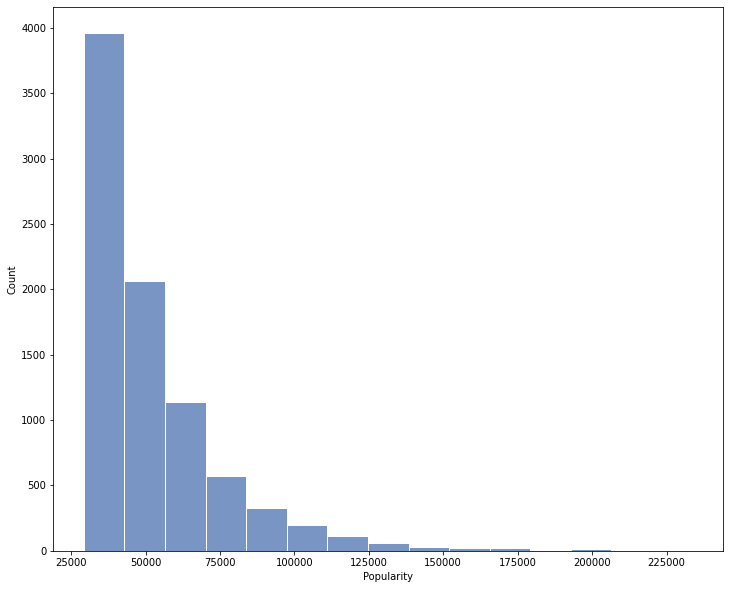

In [ ]:
# Calculate Interquartile Range
Q95 = quantile(noDummies['Popularity'], 0.95)
print("95th Percentile:", Q95)

# Subset the Outliers 
outlierDAT = noDummies[(noDummies['Popularity'] > 29287)]
# Sort the Outliers
outlierDAT.sort_values(by=['Popularity'], inplace=True, ascending=False)
#print(outlierDAT.shape)

# Histogram of Outlier Popularity values
fig, ax = plt.subplots(figsize=(12, 10))
sns.set_theme(style="darkgrid")
sns.histplot(data=outlierDAT, x='Popularity', bins = 15)

In [ ]:
# Remove Outliers from noDummies
noDummies_outliersRemoved = noDummies[(noDummies['Popularity'] < 29287)]

print(noDummies_outliersRemoved.shape)

(162100, 82)


Finally, subset the data set into 5 separate ones for each of the countries of interest.

In [ ]:
# Subset by Country
globalDat = noDummies_outliersRemoved[(noDummies_outliersRemoved["Country"] == "Global")]
usaDat = noDummies_outliersRemoved[(noDummies_outliersRemoved["Country"] == "USA")]
finlandDat = noDummies_outliersRemoved[(noDummies_outliersRemoved["Country"] == "Finland")]
singaporeDat = noDummies_outliersRemoved[(noDummies_outliersRemoved["Country"] == "Singapore")]
newZealandDat =noDummies_outliersRemoved[(noDummies_outliersRemoved["Country"] == "New Zealand")]

### Popularity CSV

Bring in data, remove unwanted columns, and rename columns to match formatting in the final csv.

In [ ]:
#Bring in the csv
popularityRAW = pd.read_csv("Database to calculate popularity.csv")
#Make a copy to play with
pop = popularityRAW

#Remove columns we aren't interested in
pop = pop.drop(columns={'Unnamed: 0'})
#Rename columms to match format.
pop = pop.rename(columns={'country':'Country','date':'Date','position':'Position', 'uri':'Uri','track':'Track','title':'Title','artist':'Artist'})

### Join each final country subset with position data from the popularity csv.

In [ ]:
#We want Country and Uri for joining. The only unique information we are trying to bring over is the position. Date, Track, Title, and Artist are already present.
pop = pop.drop(columns=['Track', 'Title', 'Artist'])

## Join pop with each Country subset on Uri and Country

#Select countries of interest
countries = ['USA', 'Global', 'Finland', 'Singapore', 'New Zealand']
pop_CountrySelection = pop[pop['Country'].isin(countries)]

# Join the datasets
globalJoin = pop_CountrySelection.merge(globalDat, on=['Uri', 'Country'])
usaJoin = pop_CountrySelection.merge(usaDat, on=['Uri', 'Country'])
finlandJoin = pop_CountrySelection.merge(finalDat, on=['Uri', 'Country'])
singaporeJoin = pop_CountrySelection.merge(singaporeDat, on=['Uri', 'Country'])
newZealandJoin = pop_CountrySelection.merge(newZealandDat, on=['Uri', 'Country'])

# Exploratory Data Analysis

## Popularity csv

Start by creating a single joined data frame that represents our 5 countries in one.

In [ ]:
# Generate merged data frame with all countries of interest
finalComb = noDummies_outliersRemoved[['Country','Genre','Uri', 'Artist', 'Popularity']]
#Select countries of interest
countries = ['USA', 'Global', 'Finland', 'Singapore', 'New Zealand']
finalComb = finalComb[finalComb['Country'].isin(countries)]
spotJoin = pop.merge(finalComb, on=['Uri', 'Country'])

#Go ahead and drop Uri
spotJoin = spotJoin.drop(columns='Uri')
spotJoin.head(n=1)

,Country,Date,Position,Genre,Artist,Popularity
0,Global,05/11/2020,1.0,latin,Bad Bunny - Jhay Cortez,3160.6


Extract the year and month to use for grouping.

In [ ]:
#Change to datetime
spotJoin['Date'] = pd.to_datetime(spotJoin.Date)
 
#Extract (https://www.interviewqs.com/ddi-code-snippets/extract-month-year-pandas)
spotJoin['Year'] = pd.DatetimeIndex(spotJoin['Date']).year
spotJoin['Month'] = pd.DatetimeIndex(spotJoin['Date']).month

* **Are there any differences by Year for the counts of the Genres?** 

In [ ]:
#Groupby appriate columns of interest.
YearGenre = spotJoin.groupby(['Year', 'Genre']).size().reset_index()
YearGenre.columns = ['Year', 'Genre', 'Count']

#Look at results numerically by Count 
YG = YearGenre.sort_values(['Year','Count'], ascending=False)

# Seperate out each year
YG_2020 = YG[YG.Year==2020]
YG_2019 = YG[YG.Year==2019]
YG_2018 = YG[YG.Year==2018]
YG_2017 = YG[YG.Year==2017]

#Use pandas nlargest and nsmallest to select the largest and smallest rows based on the Count column. 
L2020 = YG_2020.nlargest(10, 'Count')
L2019 = YG_2019.nlargest(10, 'Count')
L2018 = YG_2018.nlargest(10, 'Count')
L2017 = YG_2017.nlargest(10, 'Count')

S2020 = YG_2020.nsmallest(10, 'Count')
S2019 = YG_2019.nsmallest(10, 'Count')
S2018 = YG_2018.nsmallest(10, 'Count')
S2017 = YG_2017.nsmallest(10, 'Count')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text major ticklabel objects>)

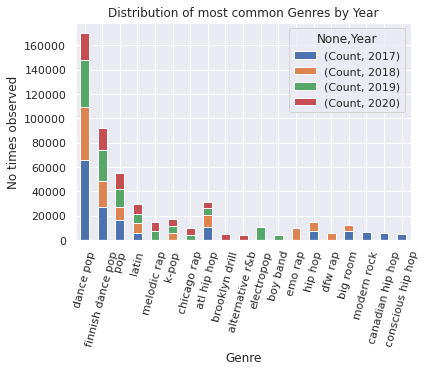

In [ ]:
##For the most commonly seen genres##

#Combine all largest values for the years
frames = [L2020, L2019, L2018, L2017]
result = pd.concat(frames)

#Let's create a new structure to this where each year gets its own column and is filled by count. 
play = result.set_index('Genre')
play2 = play.pivot(columns='Year')
play2.plot(kind='bar', stacked='True')
plt.ylabel('No times observed')
plt.title('Distribution of most common Genres by Year')
plt.xticks(rotation=75, horizontalalignment="center")
#plt.savefig('Distribution of most common Genres by Year', orientation='landscape', bbox_inches='tight')

There are a few genres that are highly represented in each year. These are dance pop, finish dance pop, pop, and latin. The other highly represented genres are far lower than these and normally just present in one or two years. 

k-pop though us represented in the last three consecutive years.

* **Are there differences by Country for the counts in each Genre?**

In [ ]:
#We will start back with spotJoin
spotJoin.head()

#Group by country and then get counts by Genre
CountryGenre = spotJoin.groupby(['Country', 'Genre']).size().reset_index()
CountryGenre.columns = ['Country', 'Genre', 'Count']

#Look at results numerically by Count 
CG = CountryGenre.sort_values(['Country','Count'], ascending=False)
CG

# Seperate out each country
CG_Global = CG[CG.Country=='Global']
CG_USA = CG[CG.Country=='USA']
CG_Singapore = CG[CG.Country=='Singapore']
CG_Finland = CG[CG.Country=='Finland']
CG_NewZ = CG[CG.Country=='New Zealand']

#Use pandas nlargest and nsmallest to select the largest and smallest rows based on the Count column. 
LGlob = CG_Global.nlargest(10, 'Count')
LUSA = CG_USA.nlargest(10, 'Count')
LSing = CG_Singapore.nlargest(10, 'Count')
LFin = CG_Finland.nlargest(10, 'Count')
LNZ = CG_NewZ.nlargest(10, 'Count')

SGlob = CG_Global.nsmallest(10, 'Count')
SUSA = CG_USA.nsmallest(10, 'Count')
SSing = CG_Singapore.nsmallest(10, 'Count')
SFin = CG_Finland.nsmallest(10, 'Count')
SNZ = CG_NewZ.nsmallest(10, 'Count')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 <a list of 27 Text major ticklabel objects>)

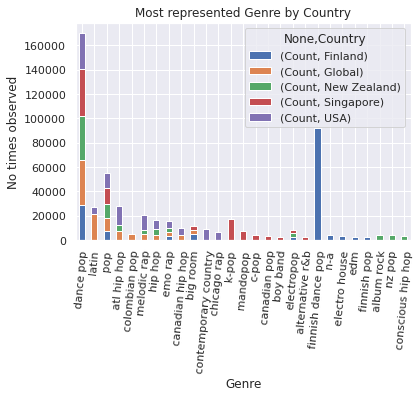

In [ ]:
##For the most commonly seen genres##

#Combine all largest values for the years
frames = [LGlob, LUSA, LSing, LFin, LNZ]
result = pd.concat(frames)

#Let's create a new structure to this where each year gets its own column and is filled by count. 
play = result.set_index('Genre')
play2 = play.pivot(columns='Country')
play2.plot(kind='bar', stacked='True')
plt.ylabel('No times observed')
plt.title('Most represented Genre by Country')
plt.xticks(rotation=85, horizontalalignment="center")
#plt.savefig('Distribution of most common Genres by Country', orientation='landscape', bbox_inches='tight')

* All 5 countries have dance pop and pop genres highly represented. 

* Genres with high representation in 4 countries:
  * dfw rap & emo rap are represented in Finlad, Global, New Zealand, and USA.
  * electo pop is represented in Finlad, Global, New Zealand, and Singapore.

* **Look at Distribution of Position by Genre**

While it is useful to get an idea of which genres are highly and lowly represented in our data, our main point of this analysis is less on being present and more on where you rank when you are present. 

For this next section, we are going to try to help artists understand how best to market their work in order to appear in the top 10 songs and to avoid being in the bottom 10 songs. 
* When trying to look at the top 10 and bottom 10 songs, there were too many rows to make graphing easily legible by genre.
* I chose next to just look at all songs in the top and bottom 5 positions.

In [ ]:
# Select all rows where position is between 190 and 200 
posHigh = spotJoin.loc[spotJoin['Position'] >= 190]

#Select all rows where position is between 1 and 10.
posLow = spotJoin.loc[spotJoin['Position'] <= 10]

In [ ]:
#Option to make pandas dataframes into presentable images (https://stackoverflow.com/questions/26678467/export-a-pandas-dataframe-as-a-table-image)
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

Counts of Genres by average top 10 Position and bottom 10 position

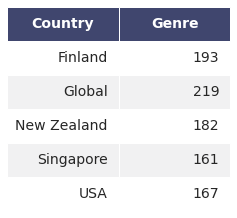

In [ ]:
#How many genres are represented in each Country in their top 10 songs?
df = posHigh.groupby('Country', as_index=False).agg({"Genre": "nunique"})
#Call the function
render_mpl_table(df, header_columns=0, col_width=2.0)

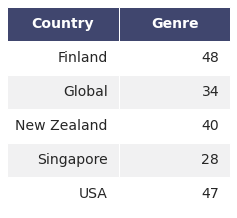

In [ ]:
df = posLow.groupby('Country', as_index=False).agg({"Genre": "nunique"})
#Call the function
render_mpl_table(df, header_columns=0, col_width=2.0)

## Final csv

We contiued our analysis by comparing the summary statistics of the five geographic subsets. 

In [ ]:
# Descriptive Statistics for the Global segment
globalDat.describe()

,Popularity,Artist_followers,Track_number,Tracks_in_album,danceability,energy,key,loudness,trackMode,speechiness,acoustics,instrumentalness,liveliness,valence,tempo,duration_ms,Days_since_release,Released_after_2017,album,compilation,single,bolero,boy band,country,danceElectronic,else,funk,hip hop,house,indie,jazz,k-pop,latin,metal,opm,pop,r&b/soul,rap,reggae,reggaeton,rock,trap,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_words,Celebrate,Desire,Explore,Fun,Hope,Love,Nostalgia,Thug,Popu_max,Top10_dummy,Top50_dummy
count,5232.000000,5.231000e+03,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5168.000000,5168.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.000000,5232.0,5232.000000,5232.000000,5232.000000,5232.0,5232.000000,5232.000000,5232.000000,5232.0,5232.000000,5232.000000,5232.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,2984.000000,5232.000000,5232.000000,5232.000000
mean,2771.490424,1.079109e+07,4.609518,10.173930,0.680593,0.636534,5.203364,-6.448142,0.573586,0.137576,0.222247,0.012460,0.181380,0.480203,122.680178,205678.423165,1234.231811,0.885642,0.606460,0.010703,0.382836,0.000382,0.016055,0.005161,0.025994,0.020260,0.010512,0.267966,0.022362,0.012424,0.0,0.022745,0.062309,0.015482,0.0,0.306002,0.031537,0.127485,0.0,0.005161,0.037271,0.010894,-0.002011,-0.313304,-1.477882,-4.164209,-0.167225,3.225536,3.398458,2.247989,3.340147,3.400134,3.032172,2.054625,3.569370,6.130027,5.962802,331.929960,0.050938,0.077748,0.173257,0.052279,0.240617,0.143767,0.066354,0.195040,94.712920,0.051797,0.274083
std,5344.398426,1.267602e+07,4.869453,9.613539,0.147821,0.169608,3.665930,2.624988,0.494603,0.123152,0.240845,0.076994,0.140136,0.224046,29.878289,52133.580024,2591.972035,0.318276,0.488581,0.102912,0.486125,0.019550,0.125699,0.071658,0.159132,0.140902,0.101999,0.442942,0.147873,0.110777,0.0,0.149103,0.241739,0.123470,0.0,0.460874,0.174780,0.333547,0.0,0.071658,0.189442,0.103816,0.928194,3.347492,4.153626,11.679735,3.967330,3.180945,2.722206,2.301342,3.196952,2.530951,2.661411,1.809212,3.121285,5.198041,4.517217,169.616566,0.219909,0.267819,0.378533,0.222626,0.427530,0.350912,0.248941,0.396298,57.484207,0.221637,0.446093
min,0.800000,9.000000e+00,1.000000,1.000000,0.125000,0.013700,0.000000,-34.475000,0.000000,0.023500,0.000002,0.000000,0.019700,0.026200,45.780000,30133.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.000000,-19.650000,-31.000000,-63.000000,-18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,63.200000,2.394814e+06,1.000000,1.000000,0.591000,0.535000,1.000000,-7.576750,0.000000,0.046800,0.038100,0.000000,0.097600,0.305000,97.985750,176409.500000,371.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.000000,-2.062500,-3.000000,-9.000000,-2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,3.000000,212.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000,0.000000
50%,391.100000,5.647016e+06,2.000000,11.500000,0.697000,0.651000,

In [ ]:
# Descriptive Statistics for the USA segment
usaDat.describe()

,Popularity,Artist_followers,Track_number,Tracks_in_album,danceability,energy,key,loudness,trackMode,speechiness,acoustics,instrumentalness,liveliness,valence,tempo,duration_ms,Days_since_release,Released_after_2017,album,compilation,single,bolero,boy band,country,danceElectronic,else,funk,hip hop,house,indie,jazz,k-pop,latin,metal,opm,pop,r&b/soul,rap,reggae,reggaeton,rock,trap,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_words,Celebrate,Desire,Explore,Fun,Hope,Love,Nostalgia,Thug,Popu_max,Top10_dummy,Top50_dummy
count,6437.000000,6.437000e+03,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6352.000000,6352.000000,6437.000000,6437.000000,6437.000000,6437.0,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.0,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,6437.000000,4363.000000,4363.000000,4363.000000,4363.00000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,4363.000000,6437.000000,6437.000000,6437.000000
mean,2353.953208,9.561874e+06,5.285226,11.402206,0.676263,0.619871,5.183937,-6.736003,0.600280,0.149964,0.220258,0.013990,0.182406,0.458003,122.287746,204638.707783,1259.876889,0.885233,0.679820,0.008389,0.311791,0.0,0.016001,0.036042,0.023303,0.028119,0.002175,0.297654,0.013982,0.008700,0.000155,0.015535,0.023769,0.010875,0.0,0.270157,0.038061,0.172285,0.000311,0.001554,0.033090,0.008234,-0.030484,-0.498602,-1.672473,-5.24639,-0.299106,3.468943,3.578730,2.413477,3.576209,3.548247,3.207426,2.165482,3.804492,6.572771,6.273665,340.372221,0.038964,0.074948,0.171442,0.046069,0.228742,0.123539,0.078157,0.238139,86.798509,0.082958,0.329657
std,4834.307276,1.198242e+07,5.143864,9.447639,0.150422,0.168739,3.668780,2.663256,0.489879,0.131850,0.243991,0.086168,0.137415,0.219410,29.849923,53849.743200,2683.506858,0.318766,0.466582,0.091214,0.463261,0.0,0.125490,0.186408,0.150875,0.165325,0.046589,0.457262,0.117424,0.092873,0.012464,0.123678,0.152340,0.103721,0.0,0.444075,0.191359,0.377657,0.017625,0.039387,0.178885,0.090372,0.931755,3.531078,4.349078,12.49253,4.089683,3.299665,2.790142,2.393350,3.351808,2.613082,2.748068,1.902273,3.262975,5.413520,4.700065,171.100087,0.193531,0.263338,0.376938,0.209659,0.420071,0.329092,0.268450,0.425993,58.103709,0.275840,0.470125
min,0.800000,1.200000e+01,1.000000,1.000000,0.125000,0.005430,0.000000,-34.475000,0.000000,0.022900,0.000002,0.000000,0.021500,0.026200,45.780000,30133.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-22.500000,-31.000000,-70.00000,-25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,73.600000,2.374492e+06,1.000000,1.000000,0.578000,0.515000,1.000000,-7.909000,0.000000,0.047000,0.035100,0.000000,0.099500,0.284000,97.020000,174358.000000,365.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-2.350000,-4.000000,-12.00000,-3.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,3.000000,216.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.000000,0.000000,0.000000
50%,340.000000,5.177309e+06,3.000000,13.0000

In [ ]:
# Descriptive Statistics for the Finland segment
finlandDat.describe()

,Popularity,Artist_followers,Track_number,Tracks_in_album,danceability,energy,key,loudness,trackMode,speechiness,acoustics,instrumentalness,liveliness,valence,tempo,duration_ms,Days_since_release,Released_after_2017,album,compilation,single,bolero,boy band,country,danceElectronic,else,funk,hip hop,house,indie,jazz,k-pop,latin,metal,opm,pop,r&b/soul,rap,reggae,reggaeton,rock,trap,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_words,Celebrate,Desire,Explore,Fun,Hope,Love,Nostalgia,Thug,Popu_max,Top10_dummy,Top50_dummy
count,6597.000000,6.595000e+03,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6479.000000,6479.000000,6597.000000,6597.000000,6597.000000,6597.0,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.0,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,6597.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000,6597.000000,6597.000000,6597.000000
mean,2788.186426,6.152822e+06,3.409732,7.095801,0.643373,0.671831,5.284978,-6.511686,0.532666,0.100014,0.187159,0.024550,0.186028,0.489976,121.734349,206163.283614,1165.744096,0.863251,0.451114,0.013491,0.535395,0.0,0.007428,0.000455,0.026376,0.077611,0.000758,0.083371,0.033500,0.020312,0.000455,0.010005,0.003486,0.056844,0.0,0.558587,0.014855,0.066849,0.000455,0.000152,0.035016,0.003486,-0.004329,-0.181818,-1.308321,-2.927369,-0.132275,2.873978,3.177489,2.023569,3.088504,3.197210,2.846080,1.909572,3.201058,5.577682,5.445406,312.963444,0.063011,0.081289,0.194324,0.048581,0.247715,0.166426,0.069264,0.129389,88.079278,0.082007,0.299530
std,5272.758521,1.202754e+07,3.966611,7.221370,0.145042,0.177448,3.634454,2.518634,0.498970,0.095042,0.229932,0.118973,0.139018,0.224135,28.273975,48101.999332,2012.356572,0.343609,0.497642,0.115373,0.498783,0.0,0.085869,0.021322,0.160262,0.267579,0.027522,0.276463,0.179952,0.141077,0.021322,0.099529,0.058947,0.231562,0.0,0.496593,0.120983,0.249778,0.021322,0.012312,0.183834,0.058947,0.922649,3.410808,4.246573,11.052679,3.978686,2.955638,2.555025,2.175841,3.059226,2.404394,2.538704,1.674556,2.807761,4.855229,4.151577,157.274931,0.243041,0.273344,0.395775,0.215042,0.431789,0.372552,0.253964,0.335711,57.442179,0.274396,0.458087
min,0.800000,0.000000e+00,1.000000,1.000000,0.062800,0.005430,0.000000,-26.956000,0.000000,0.023100,0.000004,0.000000,0.013800,0.026200,45.529000,30133.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-19.950000,-31.000000,-63.000000,-23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,72.000000,1.476300e+04,1.000000,1.000000,0.553000,0.569000,2.000000,-7.528000,0.000000,0.039600,0.021500,0.000000,0.097700,0.319000,99.946000,180953.000000,386.500000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.850000,-3.000000,-7.000000,-2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.000000,0.000000,0.000000
50%,422.200000,1.338760e+05,1.000000,3.

In [ ]:
# Descriptive Statistics for the Singapore segment
singaporeDat.describe()

,Popularity,Artist_followers,Track_number,Tracks_in_album,danceability,energy,key,loudness,trackMode,speechiness,acoustics,instrumentalness,liveliness,valence,tempo,duration_ms,Days_since_release,Released_after_2017,album,compilation,single,bolero,boy band,country,danceElectronic,else,funk,hip hop,house,indie,jazz,k-pop,latin,metal,opm,pop,r&b/soul,rap,reggae,reggaeton,rock,trap,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_words,Celebrate,Desire,Explore,Fun,Hope,Love,Nostalgia,Thug,Popu_max,Top10_dummy,Top50_dummy
count,3380.000000,3.378000e+03,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3379.000000,3320.000000,3320.000000,3380.000000,3380.000000,3380.000000,3380.0,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.000000,3380.0,3380.000000,3380.000000,3380.000000,3380.0,3380.000000,3380.000000,3380.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,1851.000000,3380.000000,3380.000000,3380.000000
mean,3393.934615,1.134634e+07,4.014501,9.167209,0.633497,0.626987,5.191181,-6.400888,0.622078,0.090515,0.254537,0.015774,0.177065,0.460929,120.213488,209513.197988,1348.186747,0.821084,0.523373,0.022485,0.453846,0.0,0.023669,0.002367,0.026036,0.036982,0.000592,0.078698,0.035503,0.030178,0.000296,0.145562,0.005325,0.014497,0.0,0.464497,0.039053,0.061243,0.0,0.000296,0.034320,0.000888,-0.001621,0.140005,-0.866559,-1.372771,0.033495,2.488385,2.882766,1.733117,2.701783,2.994598,2.567261,1.712588,2.889249,4.947596,4.981091,302.684495,0.067531,0.085359,0.188006,0.042680,0.297137,0.179363,0.055646,0.084279,94.173964,0.052663,0.279586
std,5727.489706,1.418691e+07,4.514705,10.711880,0.143963,0.184445,3.610413,2.677267,0.484940,0.089127,0.268209,0.097406,0.134363,0.217626,28.177781,41732.458226,2379.909075,0.383339,0.499527,0.148277,0.497939,0.0,0.152037,0.048600,0.159264,0.188746,0.024322,0.269307,0.185075,0.171101,0.017201,0.352719,0.072792,0.119545,0.0,0.498812,0.193750,0.239810,0.0,0.017201,0.182076,0.029783,0.922100,3.028486,3.878983,9.516779,3.630496,2.631668,2.326761,1.995693,2.743187,2.264646,2.350201,1.544143,2.486536,4.350205,3.739514,150.385267,0.251007,0.279491,0.390823,0.202188,0.457121,0.383759,0.229298,0.277881,57.887272,0.223392,0.448862
min,0.800000,0.000000e+00,1.000000,1.000000,0.125000,0.036700,0.000000,-23.657000,0.000000,0.023300,0.000002,0.000000,0.015100,0.033700,46.718000,35240.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.000000,-19.650000,-31.000000,-63.000000,-20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,102.400000,1.416818e+06,1.000000,1.000000,0.538000,0.505000,2.000000,-7.640000,0.000000,0.037450,0.039900,0.000000,0.095200,0.285000,98.196000,185897.000000,435.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-1.000000,-1.500000,-3.000000,-5.000000,-2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,203.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.750000,0.000000,0.000000
50%,639.550000,5.087482e+06,2.000000,9.000000,0.650000,0.642000,5.

In [ ]:
# Descriptive Statistics for the New Zealand segment
newZealandDat.describe()

,Popularity,Artist_followers,Track_number,Tracks_in_album,danceability,energy,key,loudness,trackMode,speechiness,acoustics,instrumentalness,liveliness,valence,tempo,duration_ms,Days_since_release,Released_after_2017,album,compilation,single,bolero,boy band,country,danceElectronic,else,funk,hip hop,house,indie,jazz,k-pop,latin,metal,opm,pop,r&b/soul,rap,reggae,reggaeton,rock,trap,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_words,Celebrate,Desire,Explore,Fun,Hope,Love,Nostalgia,Thug,Popu_max,Top10_dummy,Top50_dummy
count,3330.000000,3.330000e+03,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3243.000000,3243.000000,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.000000,3330.000000,3330.000000,3330.0,3330.000000,3330.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,2340.000000,3330.000000,3330.000000,3330.000000
mean,3689.195676,1.197809e+07,4.697898,10.615916,0.658583,0.618444,5.159459,-6.841457,0.602402,0.123437,0.228744,0.017537,0.180313,0.466307,120.569568,209258.564565,1768.914277,0.791551,0.634835,0.014715,0.350450,0.0,0.021922,0.003604,0.033033,0.038138,0.004505,0.180480,0.018919,0.012913,0.0,0.021021,0.003003,0.022823,0.0,0.394294,0.043243,0.128228,0.009009,0.0,0.050751,0.014114,0.012821,-0.125342,-1.263675,-3.115385,-0.054701,2.938034,3.245726,2.058547,3.112821,3.291026,2.871368,1.959402,3.370085,5.739316,5.684615,317.824786,0.062393,0.080342,0.197863,0.050427,0.241453,0.154274,0.067521,0.145726,90.782282,0.050751,0.278378
std,6155.711812,1.455671e+07,4.820605,8.888207,0.149349,0.174097,3.665756,2.786117,0.489475,0.120758,0.250149,0.097172,0.136712,0.219035,29.198042,55429.153631,3277.131840,0.406262,0.481549,0.120427,0.477183,0.0,0.146451,0.059931,0.178750,0.191558,0.066974,0.384645,0.136259,0.112916,0.0,0.143476,0.054726,0.149361,0.0,0.488772,0.203435,0.334394,0.094501,0.0,0.219521,0.117979,0.926918,3.312103,4.236909,11.186377,3.963547,3.035349,2.557731,2.266451,3.052779,2.445368,2.622646,1.702191,2.950606,5.058486,4.280725,161.974159,0.241920,0.271880,0.398474,0.218872,0.428056,0.361288,0.250976,0.352907,55.977512,0.219521,0.448268
min,0.800000,4.000000e+01,1.000000,1.000000,0.151000,0.012900,0.000000,-34.475000,0.000000,0.023100,0.000018,0.000000,0.021900,0.026200,45.780000,30133.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-1.000000,-19.650000,-31.000000,-63.000000,-18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,121.600000,1.733956e+06,1.000000,1.000000,0.570000,0.508000,1.000000,-8.060500,0.000000,0.042225,0.034225,0.000000,0.096800,0.297000,97.956750,179405.000000,463.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-1.000000,-1.800000,-3.000000,-7.250000,-2.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,3.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,0.000000,0.000000
50%,753.700000,5.910376e+06,3.000000,12.000000,0.672000,0.634000,5.000000,-6.354000,1.000

Additionally we examined the Genres for each of the country subsets. Specifically, it was important to see how genres were distributed. We made two observations. 

*   In most subsets 'dance pop' makes up a significant percentage of the observations
*   Genres can be so specific that common genres like "hip hop" are separated into multiple genres (e.g. concious hip hop, Canadian hip hop, Atlanta hip hop).



[Text(0, 0, 'dance pop'),
 Text(0, 0, 'alternative metal'),
 Text(0, 0, 'conscious hip hop'),
 Text(0, 0, 'canadian hip hop'),
 Text(0, 0, 'emo rap'),
 Text(0, 0, 'chicago rap'),
 Text(0, 0, 'atl hip hop'),
 Text(0, 0, 'alternative r&b'),
 Text(0, 0, 'pop'),
 Text(0, 0, 'german hip hop'),
 Text(0, 0, 'k-pop'),
 Text(0, 0, 'n-a'),
 Text(0, 0, 'melodic rap'),
 Text(0, 0, 'latin'),
 Text(0, 0, 'french hip hop'),
 Text(0, 0, 'italian hip hop'),
 Text(0, 0, 'deep german hip hop'),
 Text(0, 0, 'canadian pop'),
 Text(0, 0, 'detroit hip hop'),
 Text(0, 0, 'big room'),
 Text(0, 0, 'boy band'),
 Text(0, 0, 'modern rock'),
 Text(0, 0, 'hip hop'),
 Text(0, 0, 'colombian pop'),
 Text(0, 0, 'adult standards'),
 Text(0, 0, 'francoton'),
 Text(0, 0, 'dutch hip hop'),
 Text(0, 0, 'finnish dance pop')]

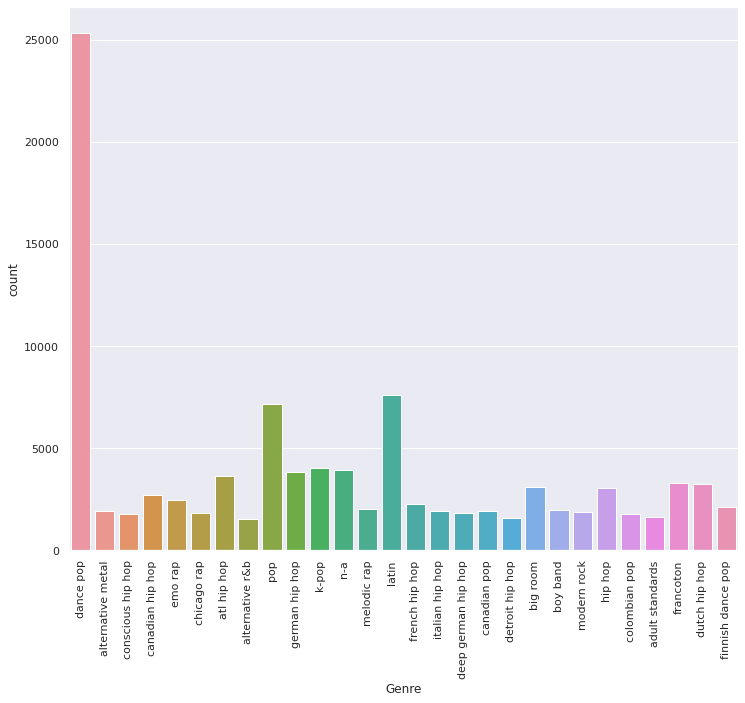

In [ ]:
# Filter out genres with less than 1500 observations
finalDatGenreCT = noDummies.groupby("Genre").filter(lambda x: len(x) > 1500)

finalDatGenreCT['Genre'] = finalDatGenreCT.Genre.astype(str)

# Genre bar chart
fig, ax = plt.subplots(figsize=(12, 10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Genre", data = finalDatGenreCT)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

[Text(0, 0, 'dance pop'),
 Text(0, 0, 'atl hip hop'),
 Text(0, 0, 'pop'),
 Text(0, 0, 'melodic rap'),
 Text(0, 0, 'latin'),
 Text(0, 0, 'hip hop')]

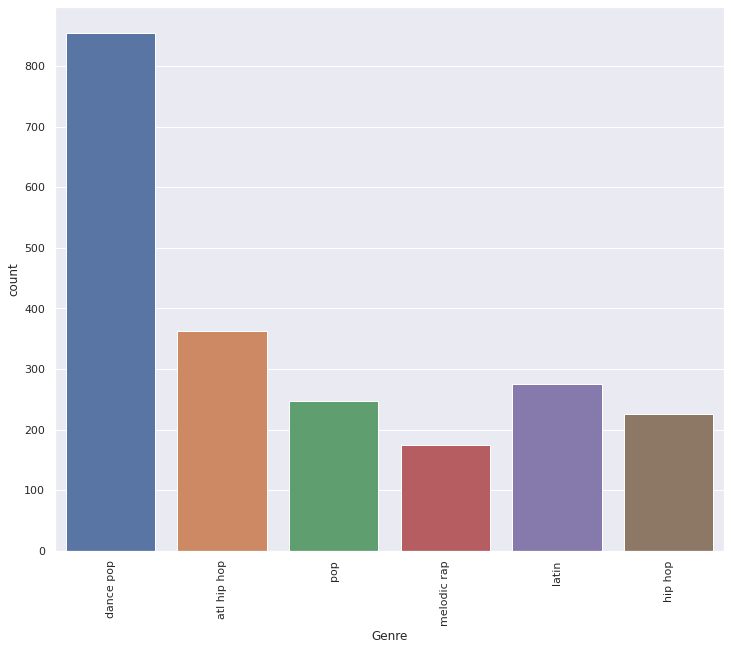

In [ ]:
# Filter out genres with less than 150 observations
globalDatGenreCT = globalDat.groupby("Genre").filter(lambda x: len(x) > 150)

globalDatGenreCT['Genre'] = globalDatGenreCT.Genre.astype(str)

# Genre bar chart
fig, ax = plt.subplots(figsize=(12, 10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Genre", data = globalDatGenreCT)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

[Text(0, 0, 'dance pop'),
 Text(0, 0, 'conscious hip hop'),
 Text(0, 0, 'canadian hip hop'),
 Text(0, 0, 'emo rap'),
 Text(0, 0, 'chicago rap'),
 Text(0, 0, 'atl hip hop'),
 Text(0, 0, 'alternative r&b'),
 Text(0, 0, 'pop'),
 Text(0, 0, 'melodic rap'),
 Text(0, 0, 'contemporary country'),
 Text(0, 0, 'hip hop')]

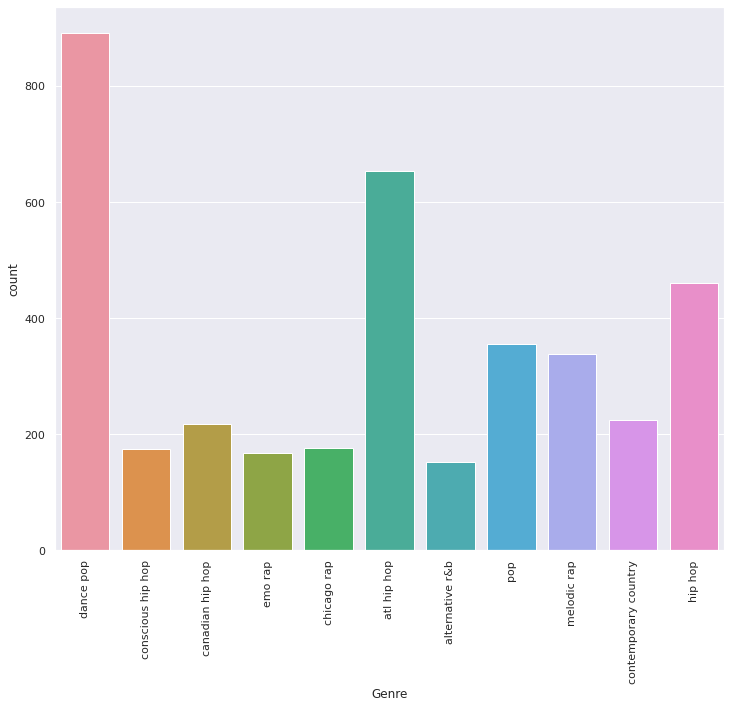

In [ ]:
# Filter out genres with less than 150 observations
usaDatGenreCT = usaDat.groupby("Genre").filter(lambda x: len(x) > 150)

usaDatGenreCT['Genre'] = usaDatGenreCT.Genre.astype(str)

# Genre bar chart
fig, ax = plt.subplots(figsize=(12, 10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Genre", data = usaDatGenreCT)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

[Text(0, 0, 'dance pop'),
 Text(0, 0, 'alternative metal'),
 Text(0, 0, 'pop'),
 Text(0, 0, 'n-a'),
 Text(0, 0, 'finnish dance pop'),
 Text(0, 0, 'finnish hip hop')]

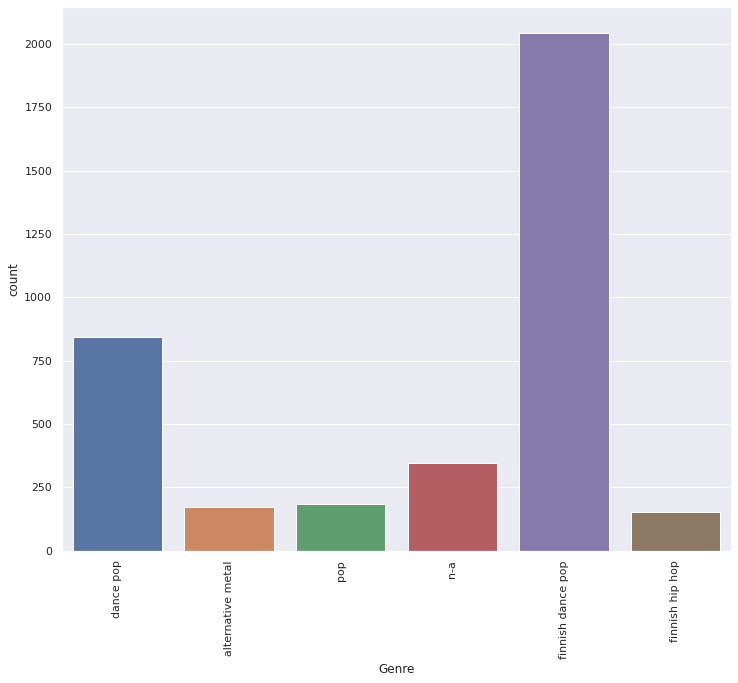

In [ ]:
# Filter out genres with less than 150 observations
finlandDatGenreCT = finlandDat.groupby("Genre").filter(lambda x: len(x) > 150)

finlandDatGenreCT['Genre'] = finlandDatGenreCT.Genre.astype(str)

# Genre bar chart
fig, ax = plt.subplots(figsize=(12, 10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Genre", data = finlandDatGenreCT)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

[Text(0, 0, 'dance pop'), Text(0, 0, 'pop'), Text(0, 0, 'k-pop')]

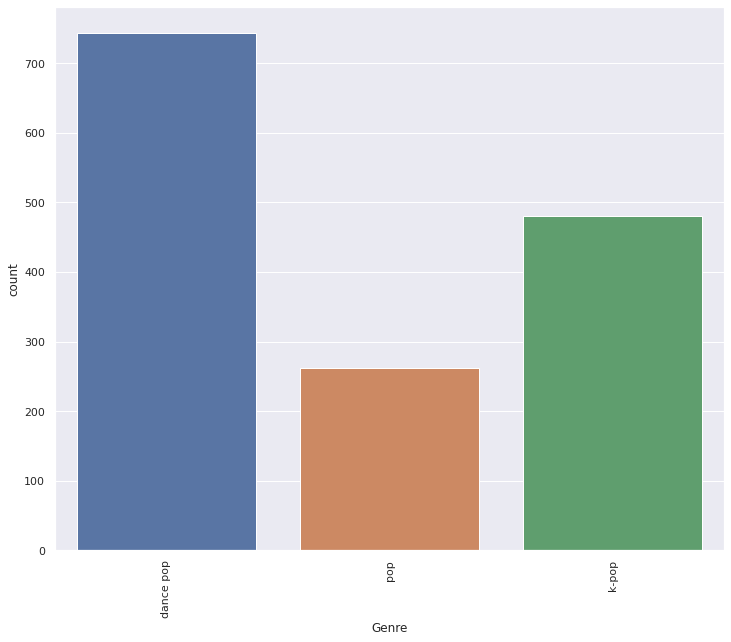

In [ ]:
# Filter out genres with less than 150 observations
singaporeDatGenreCT = singaporeDat.groupby("Genre").filter(lambda x: len(x) > 150)

singaporeDatGenreCT['Genre'] = singaporeDatGenreCT.Genre.astype(str)

# Genre bar chart
fig, ax = plt.subplots(figsize=(12, 10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Genre", data = singaporeDatGenreCT)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

[Text(0, 0, 'dance pop'), Text(0, 0, 'pop')]

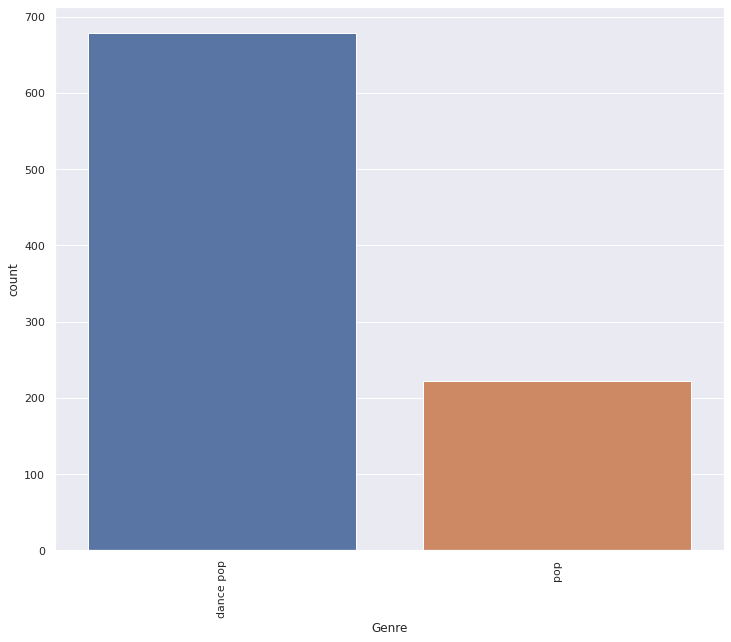

In [ ]:
# Filter out genres with less than 150 observations
newZealandDatGenreCT = newZealandDat.groupby("Genre").filter(lambda x: len(x) > 150)

newZealandDatGenreCT['Genre'] = newZealandDatGenreCT.Genre.astype(str)

# Genre bar chart
fig, ax = plt.subplots(figsize=(12, 10))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Genre", data = newZealandDatGenreCT)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

We also looked at the correlation of most of the numeric variables. The correlation matrix below shows some of the more significant or representative variables. 

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


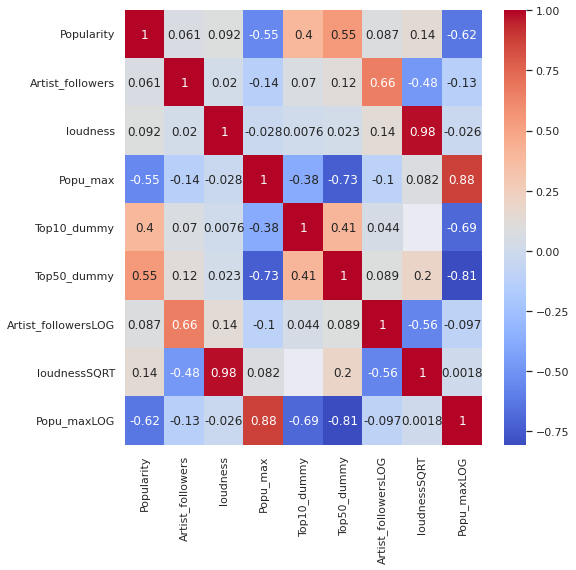

In [ ]:
dataCorr = noDummies_outliersRemoved[['Popularity', 'Artist_followers', 'loudness', 'Popu_max'
                          , 'Top10_dummy', 'Top50_dummy']]
dataCorr = dataCorr.dropna()


dataCorr['Artist_followersLOG'] = np.log10(dataCorr['Artist_followers'])
dataCorr['loudnessSQRT'] = np.sqrt(dataCorr['loudness'])
dataCorr['Popu_maxLOG'] = np.log10(dataCorr['Popu_max'])

plt.figure(figsize=(8,8))
sns.heatmap(dataCorr.corr(), annot=True, cmap='coolwarm')

One exploratory approach that was taken was to use the qualities and features of the music to categorize them by genre. A subset was created and vizualied to enhance our understanding of the relationships between genres. Genre is such a broad category it was necessary to limit the analysis to four genres, "rock", "hip hop", "latin" and "country". Attempts to analyze up to 12 genres did not result in any significant conclusions.

In [ ]:
# Create a subset with four genres and weighted with equal counts
# Hip Hop, rock, Latin, Country
noDummies['Genre_new'] = noDummies.Genre_new.astype('object')
usaDat2 = noDummies[(noDummies["Country"] == "USA")]

usaGenre1 = usaDat2.iloc[:, 13:24]
usaGenre2 = usaDat2['Genre_new']

usaGenre = pd.concat([usaGenre1, usaGenre2.reindex(usaGenre1.index)], axis=1)

usaGenre = usaGenre.loc[usaGenre['Genre_new'].isin(['rock', 'hip hop', 'latin', 'country'])]



usaGenre.head(n=1)

,danceability,energy,key,loudness,trackMode,speechiness,acoustics,instrumentalness,liveliness,valence,tempo,Genre_new
1,0.767,0.709,1.0,-4.470,1.0,0.3360,0.32300,0.000000,0.0676,0.720,171.993,hip hop
107,0.827,0.522,7.0,-4.866,1.0,0.0845,0.16300,0.000001,0.1090,0.477,151.990,hip hop
118,0.338,0.729,6.0,-6.419,0.0,0.1020,0.75800,0.000032,0.1800,0.543,184.174,hip hop
203,0.582,0.488,2.0,-8.208,1.0,0.4550,0.00168,0.000000,0.0941,0.309,80.322,hip hop
207,0.611,0.867,1.0,-5.298,1.0,0.0896,0.11000,0.000105,0.3460,0.336,140.032,hip hop
...,...,...,...,...,...,...,...,...,...,...,...,...
89400,0.734,0.468,1.0,-9.029,1.0,0.0912,0.01800,0.000000,0.3820,0.285,118.001,hip hop
89410,0.702,0.668,9.0,-9.237,1.0,0.2140,0.51800,0.000000,0.0588,0.561,116.063,rock
89423,0.615,0.871,1.0,-5.308,1.0,0.0894,0.12600,0.000059,0.3810,0.284,140.033,hip hop
89424,0.863,0.576,5.0,-5.687,0.0,0.2390,0.12400,0.000000,0.1430,0.832,132.054,hip hop


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

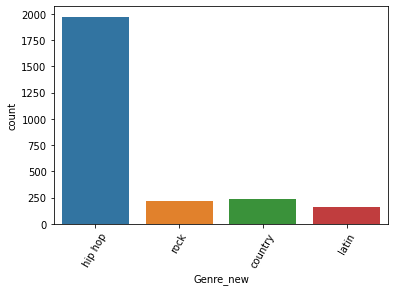

In [ ]:
sns.countplot(x="Genre_new", data=usaGenre)
plt.xticks(rotation = 60)

In [ ]:
usaGenre.head(n=2)

,danceability,energy,key,loudness,trackMode,speechiness,acoustics,instrumentalness,liveliness,valence,tempo,Genre_new
1,0.767,0.709,1.0,-4.470,1.0,0.3360,0.32300,0.000000,0.0676,0.720,171.993,hip hop
107,0.827,0.522,7.0,-4.866,1.0,0.0845,0.16300,0.000001,0.1090,0.477,151.990,hip hop
118,0.338,0.729,6.0,-6.419,0.0,0.1020,0.75800,0.000032,0.1800,0.543,184.174,hip hop
203,0.582,0.488,2.0,-8.208,1.0,0.4550,0.00168,0.000000,0.0941,0.309,80.322,hip hop
207,0.611,0.867,1.0,-5.298,1.0,0.0896,0.11000,0.000105,0.3460,0.336,140.032,hip hop


In [ ]:
# Create a sample with equal counts
usaGenre = usaGenre.groupby("Genre_new").sample(n=150, random_state=777)

usaGenre = usaGenre.reset_index(drop=True)

print("usaGenre Shape:", usaGenre.shape)
#usaGenre.tail()

usaGenre Shape: (600, 12)


In [ ]:
usaGenre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      600 non-null    float64
 1   energy            600 non-null    float64
 2   key               600 non-null    float64
 3   loudness          600 non-null    float64
 4   trackMode         600 non-null    float64
 5   speechiness       600 non-null    float64
 6   acoustics         600 non-null    float64
 7   instrumentalness  600 non-null    float64
 8   liveliness        600 non-null    float64
 9   valence           600 non-null    float64
 10  tempo             600 non-null    float64
 11  Genre_new         600 non-null    object 
dtypes: float64(11), object(1)
memory usage: 56.4+ KB


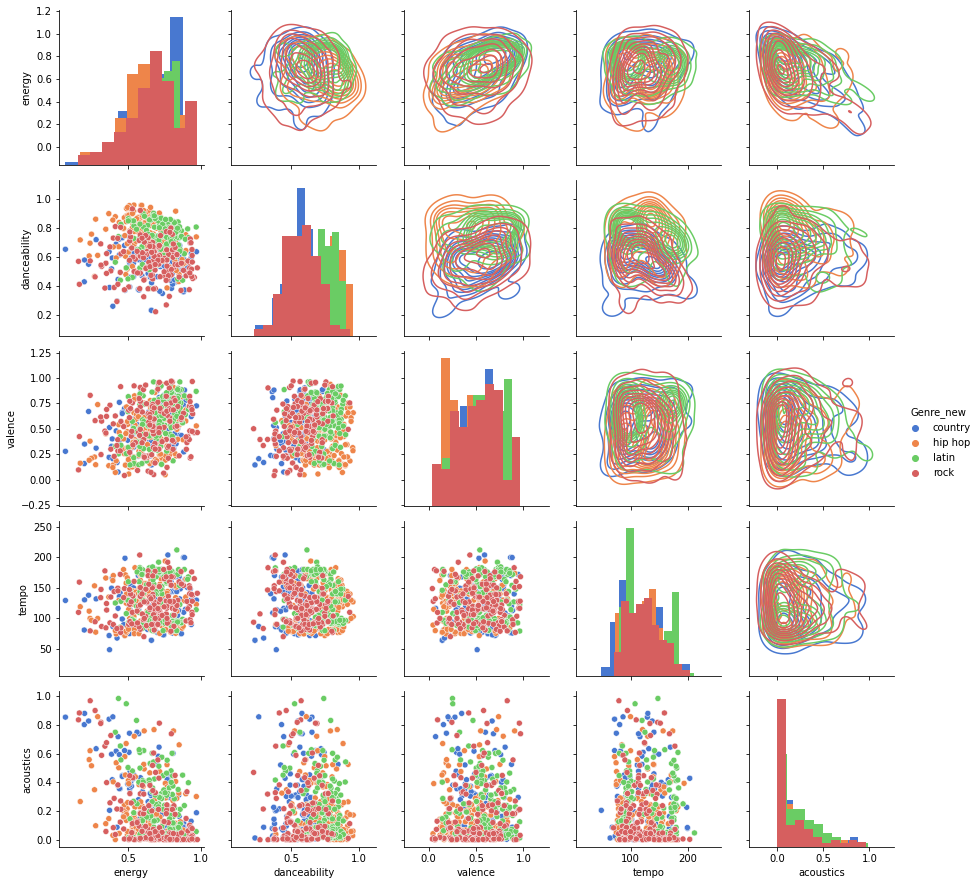

In [ ]:
# Creates a grid using Seaborn's PairGrid()
g = sns.PairGrid(
    usaGenre, 
    vars=['energy', 'danceability', 'valence', 'tempo', 'acoustics'], 
    hue='Genre_new', 
    diag_sharey=False, 
    palette=sns.color_palette('muted', n_colors=4))

# Adds histograms on the diagonal
g.map_diag(plt.hist)

# Adds density plots above the diagonal
g.map_upper(sns.kdeplot)

# Adds scatterplots below the diagonal
g.map_lower(sns.scatterplot)

# Adds a legend
g.add_legend()

## Hierarchichal Cluster Analysis

Hierarchical Cluster Analysis was performed and a dendrogram generated to visualize linkages between observations. The dendrogram shows many linkages between separate genres further proving that the music qualities of separate genres overlap in ways that make them difficult to distinguish. 

In [ ]:
# Create a sample set for Hierarchical Cluster Analysis

usaGenreSample = usaGenre.sample(50)

# Setup independant (X) and dependant (y) variables
X_hc = usaGenreSample.iloc[:, 0:10]

y_hc = usaGenreSample['Genre_new']

print('X Shape:', X_hc.shape)

X Shape: (50, 10)


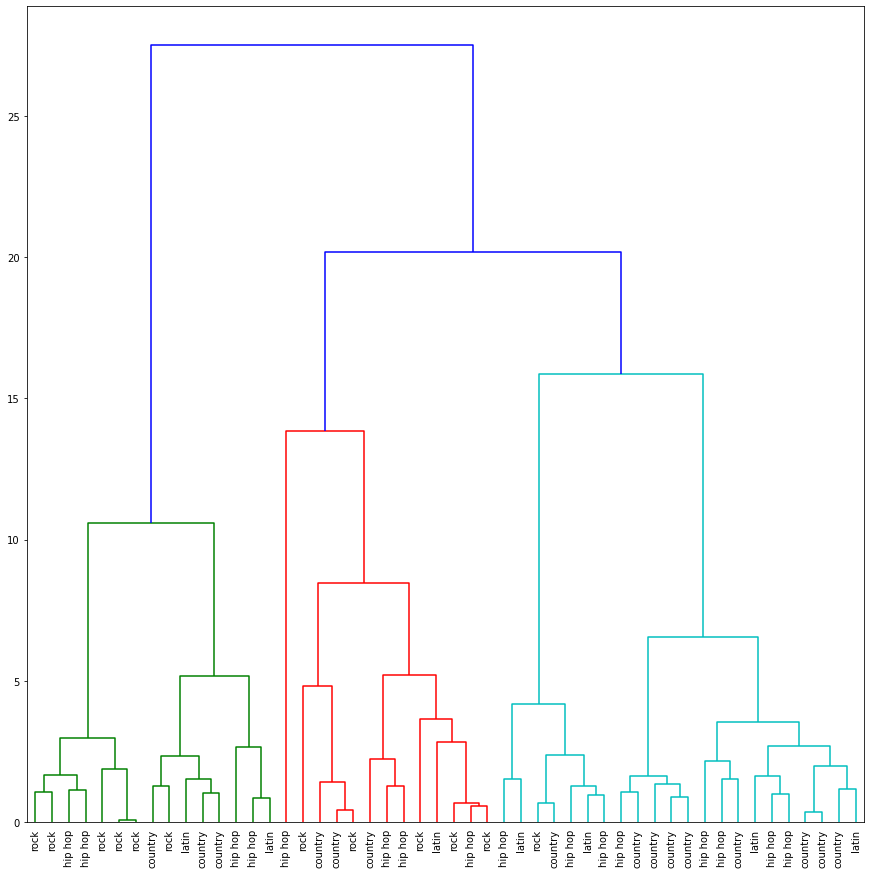

In [ ]:
# Performs agglomerative clustering using `ward` linkage and `euclidean` metric
hc = linkage(X_hc, method='ward', metric='euclidean')

# Sets the figure size
fig = plt.figure(figsize=(15, 15))

# Displays the dendogram
# The lambda function sets the labels of each leaf
dn = dendrogram(
    hc,
    leaf_label_func=lambda id: y_hc.values[id],
    leaf_font_size=10)

## K-Means Cluster Analysis

A K-Means Cluster Analysis was performed ahead of the initiating predictive models. Like the agglomerative clusering, K-means clustering was used to gain insight into the relationship between genres. The scatter plots show that each of the four genres, "rock", "hip hop", "latin" and "country", are overlapping. The analysis identified four centroids and corresponding clusters, but those clusters do not correspond with the four genres in any consistancy. 

In [ ]:
# Configure the data for k-Means Cluster Analysis

# Setup independant (X) and dependant (y) variables
X_km = usaGenre.iloc[:, 0:10]

# Standardizes the values for the features
X_km = pd.DataFrame(
    StandardScaler().fit_transform(X_km),
    columns=X_km.columns)


y_km = usaGenre['Genre_new']

print('X Shape:', X_km.shape)
print('y Shape:', y_km.shape)

X Shape: (600, 10)
y Shape: (600,)


In [ ]:
# k-Means: Train the Model

# Sets up the kMeans object
km = KMeans(
    n_clusters=4,
    random_state=1,
    init='k-means++',
    n_init=10)

# Fits the model to the data
km.fit(X_km)

# Displays the parameters of the fitted model
km.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': 1,
 'tol': 0.0001,
 'verbose': 0}

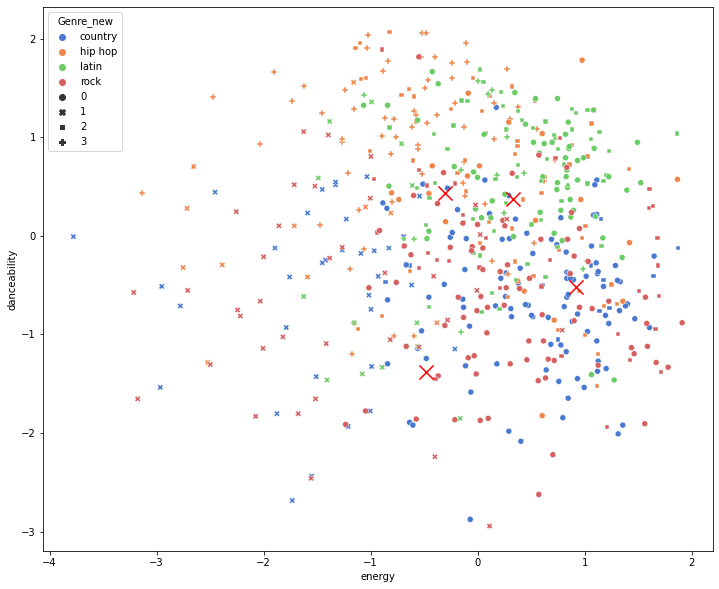

In [ ]:
# Creates a scatter plot to show clusters and centriods

fig, ax = plt.subplots(figsize=(12, 10))

sns.scatterplot(
    x='energy', 
    y='danceability',
    data=X_km, 
    hue=y_km,
    style=km.labels_,
    palette=sns.color_palette('muted', n_colors=4))

# Adds cluster centers to the same plot
plt.scatter(
    km.cluster_centers_[:,0],
    km.cluster_centers_[:,1],
    marker='x',
    s=200,
    c='red')

In [ ]:
# k-MEANS: OPTIMIZE VIA SILHOUETTE SCORES

# Sets up the custom scorer
def s2(estimator,X):
    return silhouette_score(X, estimator.predict(X))

# List of values for the parameter `n_clusters`
param = range(2,10)

# KMeans object
km = KMeans(random_state=0, init='k-means++')

# Sets up GridSearchCV object and stores in grid variable
grid = GridSearchCV(
    km,
    {'n_clusters': param},
    scoring=s2,
    cv=2)

# Fits the grid object to data
grid.fit(X_km)

# Accesses the optimum model
best_km = grid.best_estimator_

# Displays the optimum model
best_km.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 4,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

Text(0, 0.5, 'Silhouette Score')

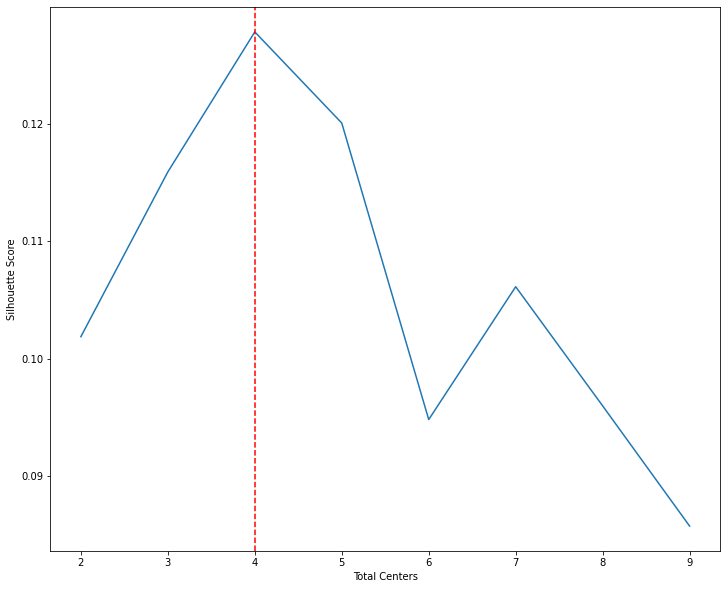

In [ ]:
# Plot mean_test_scores vs. n_clusters
fig, ax = plt.subplots(figsize=(12, 10))

plt.plot(
    param,
    grid.cv_results_['mean_test_score'])

# Draw a vertical line, where the best model is
plt.axvline(
    x=best_km.n_clusters, 
    color='red',
    ls='--')

# Adds labels to the plot
plt.xlabel('Total Centers')
plt.ylabel('Silhouette Score')

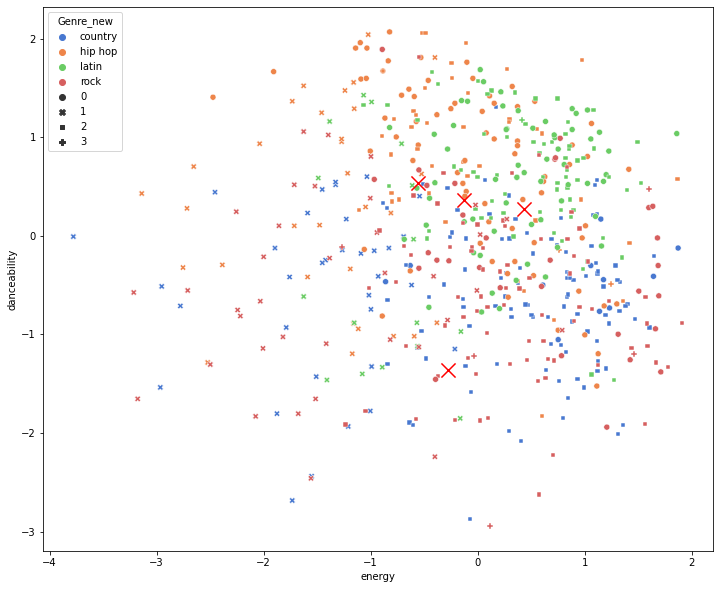

In [ ]:
# Creates a scatter plot to show optimized clusters and centriods

# Creates a scatter plot
fig, ax = plt.subplots(figsize=(12, 10))

sns.scatterplot(
    x='energy', 
    y='danceability',
    data=X_km, 
    hue=y_km,
    style=best_km.labels_,
    palette=sns.color_palette('muted', n_colors=4))

# Adds cluster centers to the same plot
plt.scatter(
    best_km.cluster_centers_[:, 0],
    best_km.cluster_centers_[:, 1],
    marker='x',
    s=200,
    c='red')

# Models

## Assign Training and Test Data

In [ ]:
# Split the Training and Test data

X_train, X_test, y_train, y_test = train_test_split(usaGenre.iloc[:, 0:11], usaGenre['Genre_new'], test_size=0.25)

# Class labels
classLabels = ['rock', 'hip hop', 'latin', 'country']

print('X_train Shape:', X_train.shape)
print()
print('X_test Shape:', X_test.shape)
print(X_train)

X_train Shape: (450, 11)

X_test Shape: (150, 11)
     danceability  energy   key  loudness  trackMode  speechiness  acoustics  \
200         0.863   0.576   5.0    -5.687        0.0       0.2390     0.1240   
464         0.388   0.338  10.0   -10.054        1.0       0.0328     0.6520   
512         0.593   0.749   5.0    -5.671        1.0       0.0475     0.0116   
284         0.604   0.570   7.0    -4.093        0.0       0.0331     0.1040   
33          0.634   0.516   8.0    -6.050        1.0       0.0373     0.4000   
..            ...     ...   ...       ...        ...          ...        ...   
508         0.653   0.684   7.0    -7.052        0.0       0.1990     0.0615   
113         0.569   0.807   0.0    -4.584        1.0       0.0464     0.0876   
370         0.734   0.836  10.0    -4.803        0.0       0.0735     0.0170   
76          0.632   0.804   7.0    -6.109        1.0       0.0503     0.1010   
422         0.795   0.755   5.0    -4.788        1.0       0.0454     

## Naive Bayes

The Naive Bayes Classifier is a simple probabalistic classifier based on Bayes theorem and that assumes naivety (assumed independance between the predictors/features). It predicts based on conditional probability: the probability that something will happen given that something else has already occurred. This classifier will use conditional probability to decide if a songs music qualities make it more likely to be one of the genres or another. 

The training accuracy for naive bayes model was 58.44%. Comparitivly the testing accuracy was 58.67% (in most trials the testing accuracy was less than the training accuracy). The confusion matrix shows that "rock" was predicted accurately, but the other genres "hip hop", "latin", and "country" were mislabled frequently.  

In [ ]:
## Naive Bayes ##

# Train Model
nb = GaussianNB().fit(X_train, y_train)

In [ ]:
# Calculate Mean Accuracy on Training Data

print(
    'Accuracy on training data: ' 
    + str("{:.2%}".format(nb.score(X_train, y_train))))

Accuracy on training data: 58.44%


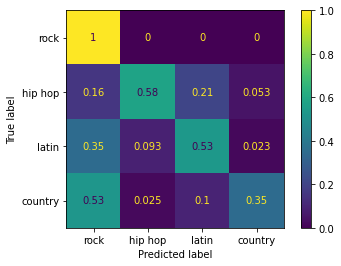

In [ ]:
# Test Model: Confusion Matrix

plot_confusion_matrix(
    nb, X_test, y_test,
    display_labels=classLabels,
    normalize='true')

In [ ]:
# Calculate Mean Accuracy on Testing Data
print(
    'Accuracy on testing data: ' 
    + str("{:.2%}".format(nb.score(X_test, y_test))))

Accuracy on testing data: 58.67%


## KNN

KNN is a supervised machine learning algorithm that can be used for both classification and regression problems. K-nearest neighbors operates by assuming that similar things live near each other. It calculates this closeness (or distance) by determining the distance between points on a graph. When using KNN, we can optimize on the number of neighbors that any given data point is likely to have. 

The training accuracy for this kNN model was 58.89%. Grid Search was used to optimize the model parameters, including k, the number of neighbors used to categorize each observation. The optimal k was found to be 7. The model can be compared to earlier plots that show how there is very little separation between genre clusters when comparing them based on music qualities. The test accuracy for this model was found to be 40%.

In [ ]:
# k Nearest Neighbors Model

# Train Model
knn = KNeighborsClassifier(n_neighbors=5) \
    .fit(X_train, y_train)

In [ ]:
# Calculate Mean Accuracy on Training Data

print(
    'Accuracy on training data: ' 
    + str("{:.2%}".format(knn.score(X_train, y_train))))

Accuracy on training data: 58.89%


In [ ]:
# Optimize the kNN Model

# Set up the kNN classifier object
knn = KNeighborsClassifier() 

# Search parameters
param = range(3, 15, 2)

# Sets up GridSearchCV object and stores it in grid variable
grid = GridSearchCV(
    knn,
    {'n_neighbors': param})

# Fits the grid object and gets the best model
best_knn = grid \
    .fit(X_train, y_train) \
    .best_estimator_

# Displays the optimum model
best_knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 7,
 'p': 2,
 'weights': 'uniform'}

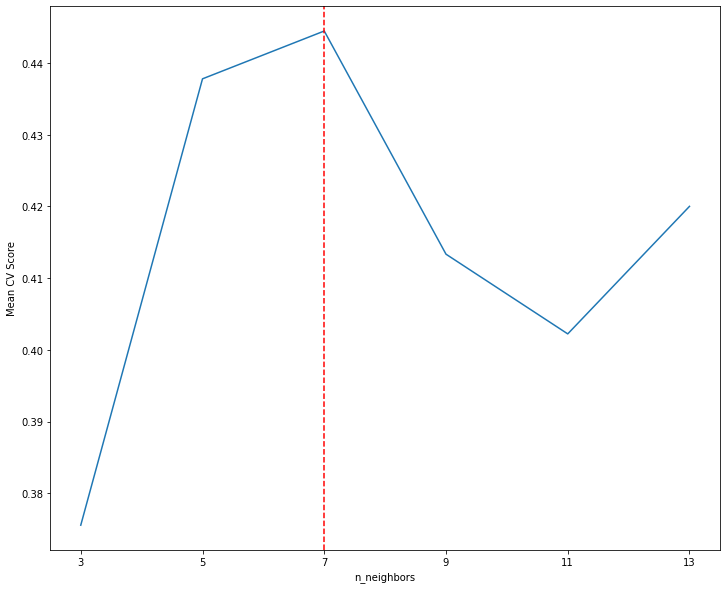

In [ ]:
# Plots mean_test_scores vs. total neighbors
fig, ax = plt.subplots(figsize=(12, 10))
plt.plot(
    param,
    grid.cv_results_['mean_test_score'])

# Adds labels to the plot
plt.xticks(param)
plt.ylabel('Mean CV Score')
plt.xlabel('n_neighbors')

# Draws a vertical line where the best model is
plt.axvline(
    x=best_knn.n_neighbors, 
    color='red', 
    ls='--')

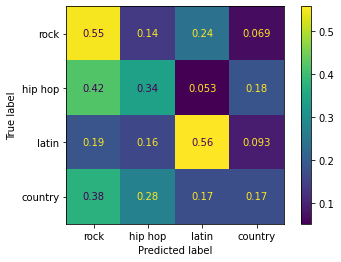

In [ ]:
# Test Model: Confusion Matrix

plot_confusion_matrix(
    best_knn, X_test, y_test,
    display_labels=classLabels,
    normalize='true')

In [ ]:
# Calculate Mean Accuracy on Testing Data
print(
    'Accuracy on testing data: ' 
    + str("{:.2%}".format(best_knn.score(X_test, y_test))))

Accuracy on testing data: 40.00%


## Decision Tree

A decision tree is a branching tree-like structure in which each node represents a binary "decision" that leads to other nodes or culminates in a classification. Using a decision tree is advantages as it allows the user to visualize the critical distinctions with the model. 

The training accuracy for this decision tree model was 64.44%. Grid Search was used to optimize the model parameters, entropy and gini.  The first node of the model attempts to separate predicted "rock" observations from "hip hop". In comparison to the dendrogram produced earlier, it may be difficult to distinctly identify rock and hip hop based on the features. The test accuracy for this model was found to be 58.67%. The confusion matrix shows how observations were mislabled. For example "latin" observations were predicted to be "hip hop" in 26% of the "latin" observations.


In [ ]:
# Decision Tree Model

# Creates a DecisionTreeClassifier object
dt = DecisionTreeClassifier(
    criterion='entropy',
    random_state=0,
    max_leaf_nodes=7) 

# Fits the decision tree to training data
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=7,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
# Calculate Mean Accuracy on Training Data
print(
    'Accuracy on training data: ' 
    + str("{:.2%}".format(dt.score(X_train,y_train))))

Accuracy on training data: 64.44%


In [ ]:
# Defines a DecisionTreeClassifier object
dt = DecisionTreeClassifier(
    random_state=1) 

# Possible values for max_leaf_nodes to try
param = range(6,45,2)

# Sets up GridSearchCV object and stores it in grid variable
grid = GridSearchCV(
    dt,
    {'max_leaf_nodes': param, 
     'criterion': ['entropy','gini']})

# Fits the grid to the training data 
grid.fit(X_train,y_train)

# Stores the optimum model in best_dt
best_dt = grid.best_estimator_

# Displays the optimum model
best_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': 18,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 1,
 'splitter': 'best'}

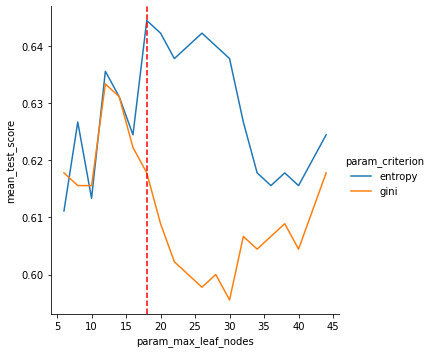

In [ ]:
# Plots the mean accuracy against max_leaf_nodes
sns.relplot(
    data=pd.DataFrame.from_dict(grid.cv_results_, orient='columns'),
    kind='line',
    x='param_max_leaf_nodes', 
    y='mean_test_score', 
    hue='param_criterion'
)

# Draws a vertical red line, where the best model is
plt.axvline(
    x=best_dt.max_leaf_nodes, 
    color='red', 
    ls='--')

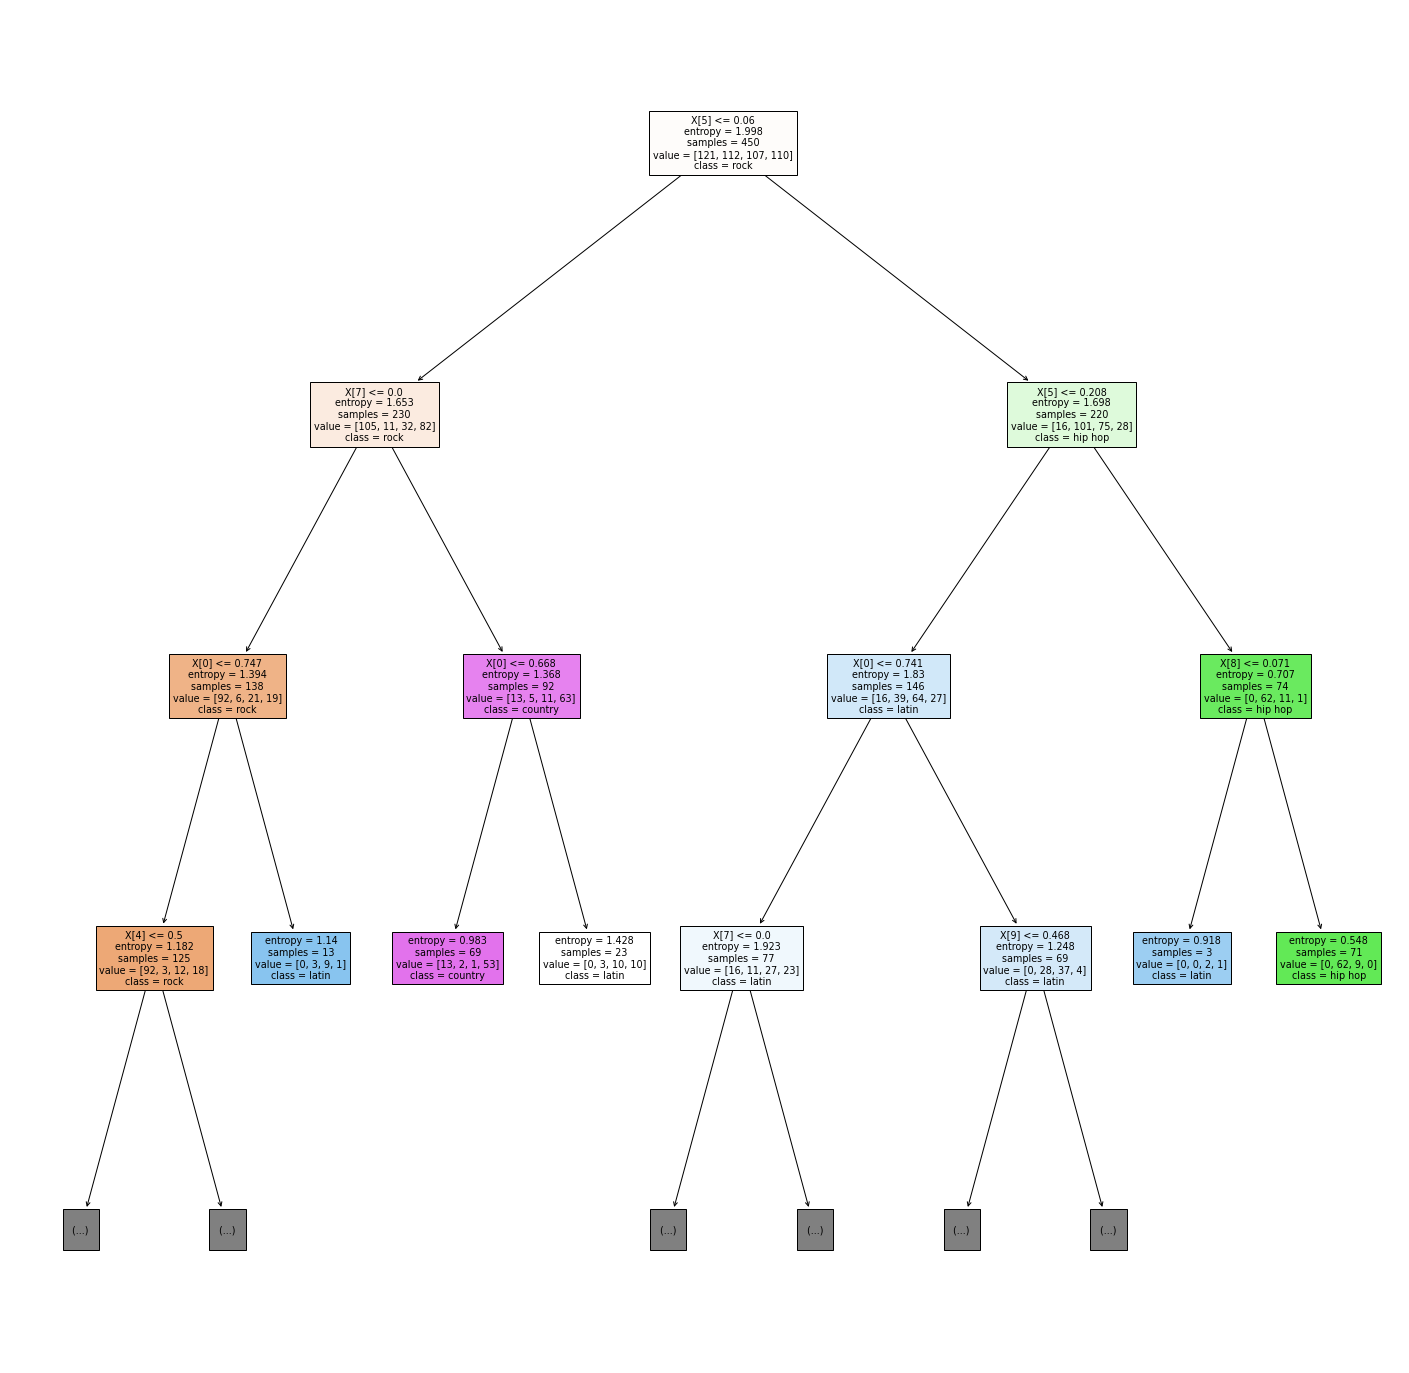

In [ ]:
# Display the Decision Tree

# Sets the figure size
fig = plt.figure(figsize=(25, 25))



# Creates a visual display of the model.
# Keep max_depth small for better visualization 
t = plot_tree(
    best_dt,
    class_names=classLabels,
    max_depth=3,
    filled=True)

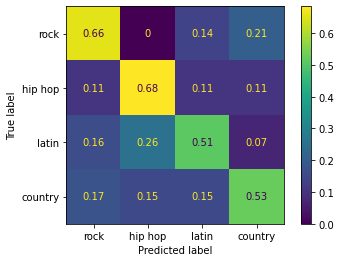

In [ ]:
# Test Model: Confusion Matrix

plot_confusion_matrix(
    best_dt, X_test, y_test,
    display_labels=classLabels,
    normalize='true')

In [ ]:
# Calculate Mean Accuracy on Testing Data
print(
    'Accuracy on testing data: ' 
    + str("{:.2%}".format(best_dt.score(X_test, y_test))))

Accuracy on testing data: 58.67%


## Random Forest

In [ ]:
rf  = RandomForestClassifier(criterion= 'entropy', random_state = 137)
rf = rf.fit(X_train, y_train)

In [ ]:
# Calculate Mean Accuracy on Training Data
print(
    'Accuracy on training data: ' 
    + str("{:.2%}".format(rf.score(X_train,y_train))))

In [ ]:
# Confusion Matrix for RandomForest

plot_confusion_matrix(
    rf, X_test, y_test,
    display_labels=classLabels,
    normalize='true')

In [ ]:
# Calculate Mean Accuracy on Testing Data
print(
    'Accuracy on testing data: ' 
    + str("{:.2%}".format(rf.score(X_test, y_test))))

In [ ]:
rf  = RandomForestClassifier(criterion= 'gini', random_state = 137, 
                             max_depth = 150, n_estimators = 75)
rf = rf.fit(X_train, y_train)

In [ ]:
# Calculate Mean Accuracy on Training Data
print(
    'Accuracy on training data: ' 
    + str("{:.2%}".format(rf.score(X_train,y_train))))

In [ ]:
# Confusion Matrix for RandomForest

plot_confusion_matrix(
    rf, X_test, y_test,
    display_labels=classLabels,
    normalize='true')

In [ ]:
# Calculate Mean Accuracy on Testing Data
print(
    'Accuracy on testing data: ' 
    + str("{:.2%}".format(rf.score(X_test, y_test))))

## Logistic Regression

Using the variables measuring the qualities of songs on a number scale, we were able to build two Logistic Regression models to predict if a song would reach the Top 50 or Top 10 on the global charts.

We split the data, 75% training and 25% testing, and after building and running the models, we found that we could accurrately predict the popularity of a song and if they will reach the Top 10 charts by up to 93.5% accurracy.

In [ ]:
# Create Top 50 Dataframe
spotify = spotJoin

spotify = spotify.drop(columns={'Country','Uri','Title_x',
                                'Artist_x','AlbumSingle','Genre','Explicit',
                                'Album','Release_date','Genre_new',
                                'LDA_Topic','Cluster','Date','Track','Top10_dummy'})

spotify['Top50_dummy'] = spotify.Top50_dummy.astype('category')
spotify = spotify.dropna()

In [ ]:
# Create Top 50 training and test sets
X = spotify.loc[:, spotify.columns != 'Top50_dummy']
y = spotify.loc[:, spotify.columns == 'Top50_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
# Run logistic regression predicting songs in Top 50
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
# Check results for Top 50
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm.T, square=True, annot=True, fmt='d',
            cmap='Blues')
plt.title('Top 50')
plt.xlabel('True')
plt.ylabel('Predicted')

print('Model Accuracy:',accuracy_score(y_test, y_pred))

In [ ]:
# Create Top 10 Dataframe
spotify = spotJoin

spotify = spotify.drop(columns={'Country','Uri','Title_x',
                                'Artist_x','AlbumSingle','Genre','Explicit',
                                'Album','Release_date','Genre_new',
                                'LDA_Topic','Cluster','Date','Track','Top50_dummy'})

spotify['Top10_dummy'] = spotify.Top50_dummy.astype('category')
spotify = spotify.dropna()

In [ ]:
# Create Top 10 training and test sets
X = spotify.loc[:, spotify.columns != 'Top10_dummy']
y = spotify.loc[:, spotify.columns == 'Top10_dummy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
# Run logistic regression predicting songs in Top 10
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
# Check results for Top 10
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm.T, square=True, annot=True, fmt='d',
            cmap='Blues')
plt.title('Top 10')
plt.xlabel('True')
plt.ylabel('Predicted')

print('Model Accuracy:',accuracy_score(y_test, y_pred))

# Analysis

Our analysis of the Spotify dataset centered around trying to predict what makes a song popular and how we may be able to predict if a track will be popular enough to make one of the Top charting spots globally. Our hypothesis going into this project was that the popularity of a song would be best predicted by the genres most popular in each country, so we started by taking a look at the Genre data.

We used Hierarchical and K-Means Cluster Analysises to explore the relationships between genres and look for distiguishing or overlapping features. Both of these cluster analysis results showed us that the qualities of various genres do differ, but for the most part, the overlapping qualities will make it difficult for the models to distinguish between genres.

With a better understanding of the data and relationships between songs and genres, we decided to build a series of models to try to predict a tracks genre based on the music qualities, and then find the most popular genres throughout individual countries. The models we decided to work with were Naive Bayes, Decision Trees, KNN, Random Forest, and Logistic Regression.

For the Naive Bayes, Decision Trees, K-Nearest Neighbors, and Random Forest, we used the data to predict the genre of a song based on its qualities. As predicted with the EDA, the models had some trouble distinguishing between the genres, with most of the results having an accurracy around 50%. The standout model for predicting the genres ended up being the Random Forest model which was 86.8% accurrate.

With further establishment that genre can be difficult to determine and with our correlation analysis of these variables revealing a strong and positive correlation between Artist Followers and Popularity, we decided to use the track quality ratings to create a Logistic Regression model to predict whether a song would chart in the Top 50 or Top 10.

The results of the two Logistical models were highly accurrate with their predictions. We were able to determine if a track would make it to the Top 50 with 86.7% confidence and Top 10 with 93.5% confidence. The results lead us to believe that a songs popularity can't just be attributed to the genre, but the specific qualities that make up the song.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('IST_718_Final_Project_Chose_another_song.ipynb')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2021-09-19 19:42:37--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0.001s  

2021-09-19 19:42:37 (2.48 MB/s) - ‘colab_pdf.py’ saved [1864/1864]





Extracting templates from packages: 100%
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/IST_718_Final_Project_Chose_another_song.ipynb to pdf
[NbConvertApp] Support files will be in IST_718_Final_Project_Chose_another_song_files/
[NbConvertApp] Making directory ./I

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'